# Machine Learning - Project 2:
# _Autoencoder for mathematical modeling of blood flow in a stenosis context_

## Context

In this project, we are going to analyze data derived from...

Our goals:
1. modeliser mathématiquement l’écoulement sanguin à l’aide de PDE dépendante de 2-3 paramètres physique
2. simuler l’écoulement par un code d’éléments fini ou similaire
3. générer beaucoup de solutions avec une grande nombre de paramètres différents. (Les 2-3, pris de façon aléatoire)
4. a. utiliser les solutions numérique pour établir un auto encoder qui au milieu n’ai que 2-5 hyper-paramètres libres  
b. quel erreur on obtient ? Est-ce possible de réduire le nombre d’hyper-paramètres ?
5. étudier s’il y a une rélation entre les 2-5 hyper-paramètre et les paramètres physique  
a. à l’aide de statistiques
5. b. à l’aide d’un DNN (différent de 4a)
6. (optionnel) faire un DNN entre l’input de 4a et output les paramêtres physique. Et/ou l’inverse.
7. Discussion et conclusions 

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Pickle](#pickle)

[4. Autoencoder](#autoencoder)

### Imports  <a name="1imports"></a>

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from autoencoder import *
from crossvalidation import *
import _pickle as cPickle
%load_ext autoreload
%autoreload 2

## 1. Data exploration  <a name="data_exploration"></a>

### Pathways <a name="1pathways"></a>

In [ ]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_very_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_very_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [ ]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [4]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (137725, 110)
Our input array Uy is of shape: (143234, 110)
Printing a row of Ux: 
 [0.07843621 0.31118352 0.68245424 1.15863002 1.69435217 2.2377946
 2.73607737 3.14059293 3.41183529 3.52330289 3.63726074 3.7439734
 3.84549407 3.94281205 4.03640323 4.12650964 4.2132592  4.29672103
 4.37693287 4.45391539 4.52767992 4.59823263 4.6655769  4.72971455
 4.79064658 4.84837353 4.90289569 4.95421322 5.00232621 5.04723472
 5.08893877 5.12743839 5.16273359 5.19482437 5.22371075 5.24939272
 5.2718703  5.29114348 5.30721227 5.32007667 5.32973668 5.33619229
 5.33944353 5.33997115 5.33936904 5.33787084 5.33552701 5.33235975
 5.32837974 5.3235924  5.31800058 5.31160582 5.30440894 5.29641041
 5.28761047 5.27800926 5.26760686 5.25640331 5.24439864 5.23159284
 5.21798594 5.20357794 5.18836883 5.17235862 5.15554731 5.13793491
 5.1195214  5.1003068  5.0802911  5.05947431 5.03785642 5.01543743
 4.99221734 4.96819616 4.94337388 4.9177505  4.89132603 4.86410046
 4.8360738  4.8

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [5]:
positions =5509 #We know it from the matlab code
times = Ux.shape[1]
simulations = int(Ux.shape[0]/positions)
print("We ran ", simulations, "simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)")
print("1 simulation calculate the velocities of the blood flow at ", positions, " different positions and at ", times, " different times")

We ran  25 simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)
1 simulation calculate the velocities of the blood flow at  5509  different positions and at  110  different times


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [6]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are no None values so we can start direclty preprocess our datasets.

ADDITIONAL IDEAS FOR PREPROCESSING
- remove columns with 0 std dev?
- standardization?

Let's sample our data points into the following ratios : 

In [7]:
ratio_pts = 0.1
ratio_time = 1

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(13750, 110) (13750, 110)


In [8]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from ', 5509, ' positions to ', new_Nu, ' positions')
print('With the sampling we got from ', 110, ' time steps to ', new_Nt, ' time steps')

With the sampling we got from  5509  positions to  550  positions
With the sampling we got from  110  time steps to  110  time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery :

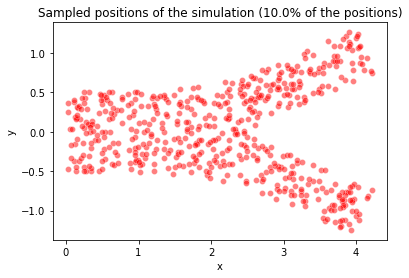

In [9]:
plot_sampled_coord(new_inds) 

In [10]:
print(new_Ux)

[[0.06598187 0.25670229 0.55084151 ... 2.51511171 2.47896831 2.44227292]
 [0.01822349 0.06614118 0.13306091 ... 0.49577011 0.48856679 0.48125408]
 [0.06441595 0.25109322 0.5398679  ... 2.481933   2.44626963 2.41006156]
 ...
 [0.06643176 0.26403555 0.57958814 ... 3.08212344 3.0383942  2.99399259]
 [0.02092091 0.07525409 0.1493795  ... 0.45401539 0.44725713 0.44039752]
 [0.02068076 0.07446069 0.14793325 ... 0.45138163 0.44466495 0.43784753]]


Let's flatten our matrices into a single matrix with dimensions $((2 N_u N_t), N_s)$. For each simulation, the x and y speed coordinates are compressed to the following 1D matrix:

$$
\mathbf{M_{1D}}
=
\begin{bmatrix}
\vdots \\
u_{x}^{(0)} \\
\vdots \\
u_{y}^{(0)} \\
\vdots \\
u_{x}^{(1)} \\
\vdots \\
u_{y}^{(1)} \\
\vdots \\
u_{x}^{(N_t - 1)} \\
\vdots \\
u_{y}^{(N_t - 1)} \\
\vdots 
\end{bmatrix}
$$



In [11]:
flattened_array = flatten(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 121000)

Let's make a sanity check that the dimension of 1 datapoint is indeed ${2 * new_{N_t} * new_{N_u})}$

In [12]:
assert flattened_array.shape[1] == 2*new_Nt*new_Nu

print(2*new_Nt*new_Nu)

121000


## 3. Pickle  <a name="pickle"></a>

To avoid the loading and processing steps each time we open the notebook, we will save the processed matrix "flattened_array" using pickle : 

Only change the following cell to change the name you want to give to the file :

In [14]:
ratios = [0.1, 1]
size = ['very_small', 'small', 'large']

name = 'processed_'+str(size[0])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file : ', name)

name of the file :  processed_very_small_0.1_1


In [15]:
cPickle.dump( flattened_array , open( "data/pickle/"+name, "wb" ) )

#### Start from here if you the pickle file already exist in your data folder

Change only the following cell to change the name of the file you want to open :

In [5]:
ratios = [0.1, 1]
size = ['very_small', 'small', 'large']

name = 'processed_'+str(size[0])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file you want to read : ', name)

name of the file you want to read :  processed_very_small_0.1_1


In [6]:
flattened_array  = cPickle.load(open("data/pickle/"+name, "rb"))

In [7]:
print(flattened_array)

[[6.59818698e-02 1.82234920e-02 6.44159502e-02 ... 2.58112106e+00
  2.11533611e-01 3.16620553e-01]
 [5.29771523e-02 1.32216300e-02 4.90189335e-02 ... 2.48800880e+00
  3.42929345e-01 4.11511611e-01]
 [8.25671280e-02 2.32952726e-02 6.87771891e-02 ... 4.44640887e+00
  2.10600093e-01 1.00067820e+00]
 ...
 [1.43603561e-01 2.09712342e-02 1.51362940e-01 ... 2.59390877e+00
  9.68726866e-01 1.00897109e+00]
 [1.99450061e-01 2.49426895e-02 1.53457337e-01 ... 1.39288807e+01
  2.20450871e-01 1.99714008e+00]
 [6.15112608e-02 1.69973304e-02 5.70614888e-02 ... 2.99399259e+00
  4.40397522e-01 4.37847533e-01]]


##### Final step : split train/test

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [8]:
# Set seed 
seed = 123
flattened_array_train, flattened_array_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = flattened_array_train, flattened_array_test

print(flattened_array_train.shape)
print(flattened_array_test.shape)

(22, 121000)
(3, 121000)


## 4. Auto-encoder  <a name="autoencoder"></a>

In [21]:
# define network parameters
learningRate=1e-2
epochs=50
input_size=flattened_array_train.shape[1]
k_folds = 5

# Set fixed random number seed
torch.manual_seed(42)

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:3954.720 Test Error:3380.605
Epoch:2/50 Training Error:440.500 Test Error:386.857
Epoch:3/50 Training Error:192.203 Test Error:116.115
Epoch:4/50 Training Error:119.484 Test Error:132.963
Epoch:5/50 Training Error:148.071 Test Error:99.031
Epoch:6/50 Training Error:46.398 Test Error:47.120
Epoch:7/50 Training Error:24.331 Test Error:16.929
Epoch:8/50 Training Error:16.767 Test Error:10.997
Epoch:9/50 Training Error:15.339 Test Error:7.992
Epoch:10/50 Training Error:7.900 Test Error:4.692
Epoch:11/50 Training Error:3.593 Test Error:2.342
Epoch:12/50 Training Error:2.136 Test Error:1.560
Epoch:13/50 Training Error:1.024 Test Error:1.144
Epoch:14/50 Training Error:1.009 Test Error:1.004
Epoch:15/50 Training Error:0.935 Test Error:0.995
Epoch:16/50 Training Error:0.902 Test Error:1.025
Epoch:17/50 Training Error:0.878 Test Error:0.986
Epoch:18/50 Training Error:0.898 Test Error:0.915
Epoch:19

Epoch:8/50 Training Error:0.848 Test Error:0.850
Epoch:9/50 Training Error:0.854 Test Error:0.797
Epoch:10/50 Training Error:0.822 Test Error:0.864
Epoch:11/50 Training Error:0.742 Test Error:0.733
Epoch:12/50 Training Error:0.711 Test Error:0.700
Epoch:13/50 Training Error:1.043 Test Error:0.689
Epoch:14/50 Training Error:0.687 Test Error:0.673
Epoch:15/50 Training Error:0.660 Test Error:0.681
Epoch:16/50 Training Error:0.645 Test Error:0.653
Epoch:17/50 Training Error:0.624 Test Error:0.641
Epoch:18/50 Training Error:0.590 Test Error:0.639
Epoch:19/50 Training Error:0.652 Test Error:0.611
Epoch:20/50 Training Error:0.606 Test Error:0.561
Epoch:21/50 Training Error:0.596 Test Error:0.548
Epoch:22/50 Training Error:0.570 Test Error:0.539
Epoch:23/50 Training Error:0.587 Test Error:0.604
Epoch:24/50 Training Error:0.649 Test Error:0.639
Epoch:25/50 Training Error:0.607 Test Error:0.648
Epoch:26/50 Training Error:0.589 Test Error:0.619
Epoch:27/50 Training Error:0.608 Test Error:0.642
Ep

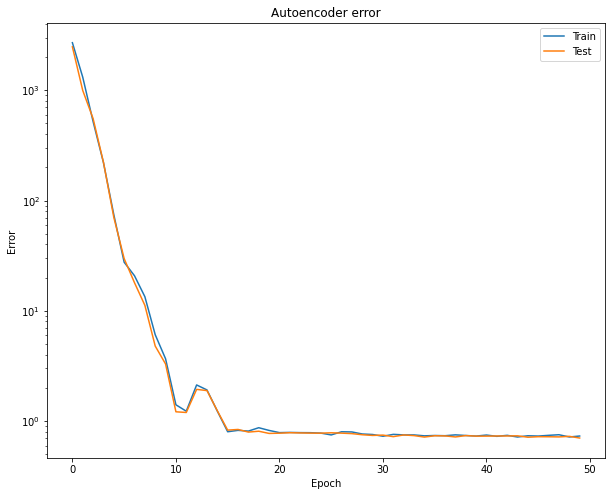

88.43040351160401

In [22]:
#Sur c'est flattened_array et pas flattened_array_train qu'il faut donner ?????
#Seed problem pas fixée
Kfold(flattened_array, k_folds, input_size, epochs, criterion, learningRate)

#### Parameters tuning

Find the best learning rate of our model using cross-validation :

In [21]:
# define network parameters
learning_rates = [0.1, 0.01] # [0.1, 0.05, 0.01, 0.005, 0.001]
epochs=1 #50
input_size=flattened_array_train.shape[1]
k_folds = 3 #5

# Set fixed random number seed
#Attention on dirait la seed est pas fixée du tout !!!!!!!!!!
torch.manual_seed(42)

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Learning rate =  0.1

Performance of 3 fold cross validation: 
Average Training Error: 15.698 	 Average Test Error: 17.203
 
Learning rate =  0.01

Performance of 3 fold cross validation: 
Average Training Error: 132.409 	 Average Test Error: 142.181
 

Best learning rate is  0.1  with a best error of :  17.203180670723285



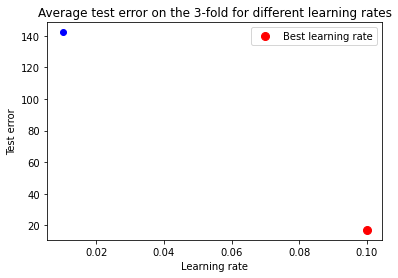

In [22]:
best_result, best_lr = tuning_lr(flattened_array_train, k_folds, input_size, epochs, criterion, learning_rates)

Find the best number of "middle neurons" in the auto-encoder (which is actually the dimension of the compressed data) : 

In [23]:
# define network parameters
lr = 0.01 # from above
epochs=1 #50
input_size=flattened_array_train.shape[1]
k_folds = 3 #5
number_neurons = [5, 6] #[3, 5, 6, 8, 10]

# Set fixed random number seed
#Attention on dirait la seed est pas fixée du tout !!!!!!!!!!
torch.manual_seed(42)

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Number of neurons =  5

Performance of 3 fold cross validation: 
Average Training Error: 85.231 	 Average Test Error: 103.523
 
Number of neurons =  6

Performance of 3 fold cross validation: 
Average Training Error: 0.982 	 Average Test Error: 0.979
 
The results obtained for the number of latent neurons tested are the following : [103.52307355789544, 0.9788119188700305].
The best average test error obtained is 0.9788119188700305, and it is obtained with 6 neurons in the latent layer.


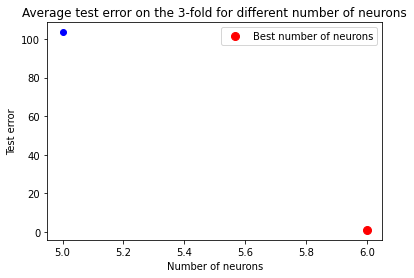

In [24]:
best_result, best_neurons_nb = tuning_middle_layer(flattened_array_train, k_folds, input_size, epochs, criterion, lr, number_neurons)

In [27]:
"""
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms

from ray import tune
from ray.tune.schedulers import ASHAScheduler

search_space = {
    "lr": tune.sample_from(lambda spec: 10**(-10 * np.random.rand())),
    "epochs": tune.uniform(1, 9)
}

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

# Download the dataset first
analysis = tune.run(tuning, config=search_space, fail_fast="raise", stop={"training_iteration": 10})

# Obtain a trial dataframe from all run trials of this `tune.run` call.
dfs = analysis.trial_dataframes
"""

ModuleNotFoundError: No module named 'ray'

## 4. Passer en 2D 

Instead of flattenning our initial dataset into a colummn vector for each simulation, we split it into a 2D matrix for each simulation such as the following:

$$
\mathbf{M_{2D}}
=
\begin{bmatrix}
\vdots & \vdots & \vdots & \vdots \\
u_{x}^{(0)} & u_{x}^{(1)} & \cdots &
u_{x}^{(N_t - 1)} \\
\vdots & \vdots & \ddots & \vdots \\
u_{y}^{(0)} & u_{y}^{(1)} & \cdots &
u_{y}^{(N_t - 1)} \\
\vdots & \vdots & \vdots & \vdots
\end{bmatrix}
$$

## 5. Hyper-parameters and physics parameters relationship

## 6. Discussion & conclusion